# Practical Session 5: Convolutional Neural Networks

*Notebook by Ekaterina Kochmar*

This practical will cover practical implementation of Convolutional Neural Networks (CNNs) with [`TensorFlow`](https://www.tensorflow.org).


## Learning objectives

In this practical you will learn about:
- The basics of CNNs
- Implementation of two building blocks in CNNs – convolutional and pooling layers with `Keras` and `TensorFlow`
- Application of CNNs to image analysis
- Classification of images from the [Fashion-MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) and the classic [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) database of hand-written digits.

**References**: Aurelien Geron, *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow*.

First, let's import a few common modules, ensure Matplotlib plots figures inline, etc. Feel free to change the settings for your own runs:

In [1]:
# A few common imports
import sklearn
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In this notebook, we will be working with images. Let's add a couple utility functions that will help you plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# First Building Block: Convolutional Layers

In this first example, we will be using sample images from the [`sklearn's` dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_sample_image.html). Let's first load the images and inspect the pixel values:

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china_img = load_sample_image("china.jpg")
flower_img = load_sample_image("flower.jpg")

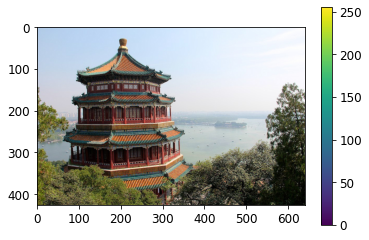

In [4]:
plt.figure()
plt.imshow(china_img)
plt.colorbar()
plt.grid(False)
plt.show()

As you can see, the values fall in the range of 0 to 255, so let's scale them to a range of 0 to 1 before feeding them to our models. To do so, divide the values by 255:

In [5]:
china = china_img / 255.0
flower = flower_img / 255.0
images = np.array([china, flower])
print(images.shape)

(2, 427, 640, 3)


Each image can be treated as a 3D tensor of the shape `[height, width, channels]`. The output above tells you that `images` is a 4D tensor – with the first dimension related to the number of images. Let's store this information in the relevant variables and then create two *filters* (*convolution kernels*). 

The first filter is a black square with a vertical white line in the middle: it is a 7x7 matrix full of 0s except for the central column, which is full of 1s. Neurons using these weights will ignore everything in their receptive field except for the central vertical line: i.e., all inputs will get multiplied by 0, except for the ones located in the central vertical line. 

The second filter is a balck square with a horizontal white line in the middle instead. Neurons using these weights will ignore everything in their receptive field except for the central horizontal line:

In [6]:
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line in the middle
filters[3, :, :, 1] = 1  # horizontal line in the middle

Now let's apply these filters as follows:

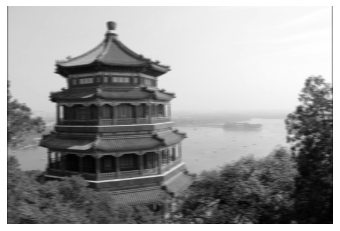

In [7]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # this will plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

The code above uses [`tf.nn.conv2d`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d), where:
- `images` are used as the input;
- `filters` created above are applied as filters to the input;
- `stride` defines the sliding window for each dimension of input; and 
- `padding` defines the [padding strategy](https://deepai.org/machine-learning-glossary-and-terms/padding): with "SAME" the convolutional layer uses zero padding if necessary. Zeros are added as evenly as possible around the inputs.

Note that most of the above are hyperparameters: you can explore the number of filters, their heights and widths, the strides, and the padding type. In practice cross-validation experiments are quite expensive on CNNs, and instead you may rely on one of the common CNN architectures available in `Keras` and `TensorFlow`.

You can also inspect the result of applying different feature maps to each of the images. The output above shows the neurons with the horizontal line filter applied to them: this makes the horizontal white lines enhanced, while the rest is blurred out. For all images and feature maps:

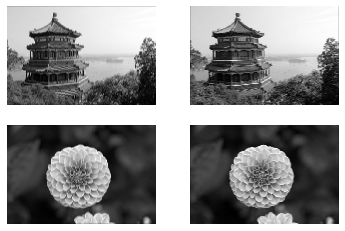

In [8]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Since it might be hard to see what's going on on these images, let's crop them by extracting sub-images. You can also save the new images with the feature maps applied to them (if that helps inspection) as follows:

In [9]:
def crop(images, rh1, rh2, rw1, rw2):
    return images[rw1:rw2, rh1:rh2]

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./images/", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Now crop the input image and inspect the results:

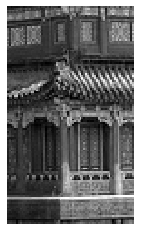

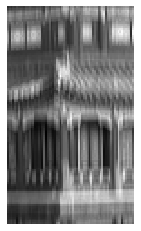

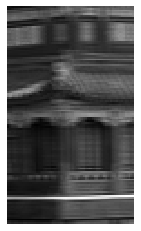

In [10]:
plot_image(crop(images[0, :, :, 0], 150, 220, 130, 250))
#save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index], 150, 220, 130, 250))
    #save_fig(filename, tight_layout=False)
    plt.show()

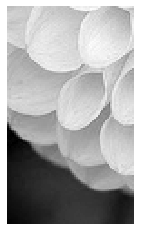

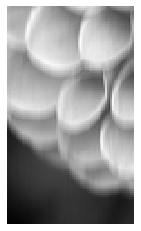

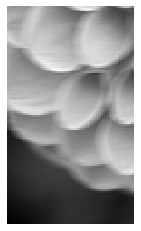

In [11]:
plot_image(crop(images[1, :, :, 0], 200, 270, 250, 370))
#save_fig("flower_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["flower_vertical", "flower_horizontal"]):
    plot_image(crop(outputs[1, :, :, feature_map_index], 200, 270, 250, 370))
    #save_fig(filename, tight_layout=False)
    plt.show()

Finally, let's also visualise the feature maps (filters):

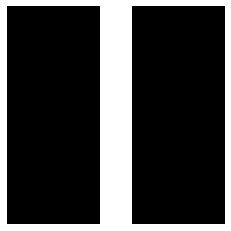

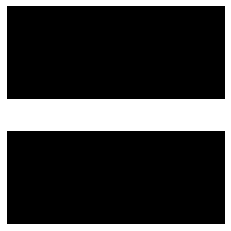

In [12]:
plot_image(filters[:, :, 0, 0]) #horizontal
plt.show()
plot_image(filters[:, :, 0, 1]) #vertical
plt.show()

Here is how you can apply a 2D convolutional layer using Keras: [`keras.layers.Conv2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): we apply 32 `filters` here (this time we are letting the network figure out the filters, rather than initialising them ourselves), with the `kernel_size` 3 (which defines equal height and width for the filters), a `stride` of 1, "SAME" `padding` scheme as above, and ReLU activation function:

In [13]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [14]:
tf.keras.backend.set_floatx('float64')
outputs = conv(images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



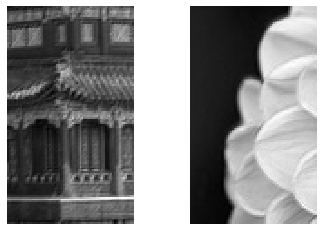

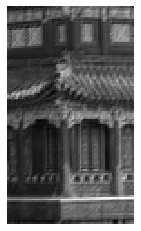

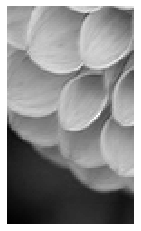

In [15]:
for image_index in (0, 1):
    plt.subplot(1, 2, image_index + 1)
    plot_image(crop(outputs[image_index, :, :, 0], 150, 220, 130, 250))

plt.show()

plot_image(crop(outputs[0, :, :, 0], 150, 220, 130, 250))
plt.show()

plot_image(crop(outputs[1, :, :, 0], 200, 270, 250, 370))
plt.show()

# Second Building Block: Pooling Layers

## Max pooling

Pooling is relatively straightforward with Keras – see the documentation at [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Below we are applying max pooling (subsampling taking the maximum value with the *pooling kernel* of 2x2):

In [16]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

Let's see what effect this has on our images. Below, we crop the images for better visibility and then apply the max pooling layer:

In [17]:
tf.keras.backend.set_floatx('float32')
cropped_images = np.array([crop(image, 150, 220, 130, 250) for image in images], dtype=np.float32)
output = max_pool(cropped_images)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Let's inspect the results. You can see that the output becomes quite a bit smaller: e.g., with a pooling kernel of 2x2 and a stride of 2, you would get an output 4 times smaller dropping 75% of the input values. The goal of this modification is to reduce the computational load, the memory usage, the number of parameters, and make the network tolerate a bit of image shift.

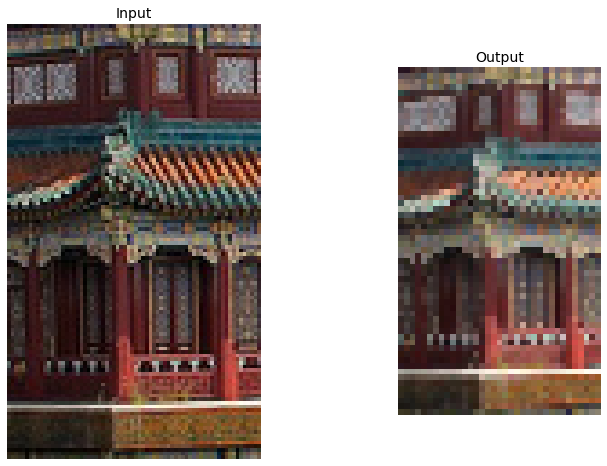

In [18]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
#save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

Normally pooling applies to every input channel independently, so the output depth is the same as input depth. However, you can also apply depth-wise pooling, which will preserve the image's input dimensions (height and width) reducing depth (number of channels). You can implement this using a custom `Lambda` layer with [`tf.nn.max_pool`](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool):

In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")) # for pool size = 3
depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 120, 70, 1])

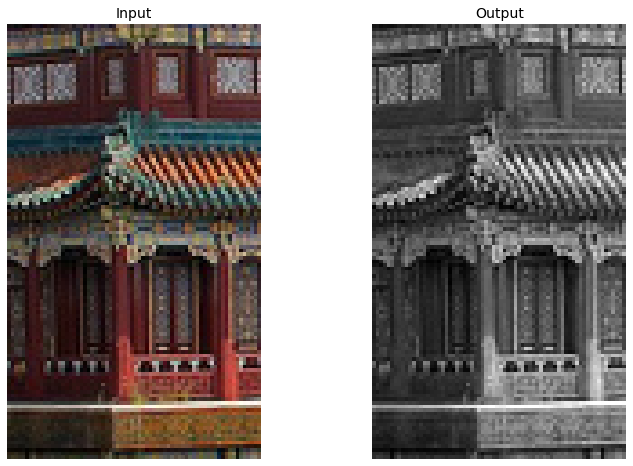

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## TASK 1 – Average pooling

Instead of max pooling, you can use average pooling. With `Keras` and `TensorFlow` this is pretty straightforward –  see [`keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) and apply this technique to the images below:

In [21]:
# Initialise average pooling:
#avg_pool = ...

In [22]:
# Apply it to cropped images
#output_avg = ...

In [23]:
# Visualise

# Tackling Fashion-MNIST with a CNN

Now let's see how we can apply CNNs to classification tasks. We are going to work with an image dataset. For a change, let's look into a new dataset – [Fashion-MNIST dataset](https://www.tensorflow.org/tutorials/keras/classification). Here is how you can load it and split into training, validation, and test sets:

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's run some sanity checks – check the dimensionality of the training set input (reminder, this should tell you the number of images, and their height and width):

In [25]:
X_train.shape

(55000, 28, 28)

Clearly, the number of labels should be equal to the number of input images:

In [26]:
len(y_train)

55000

We've looked into the images before – let's inspect the first image from this dataset, too:

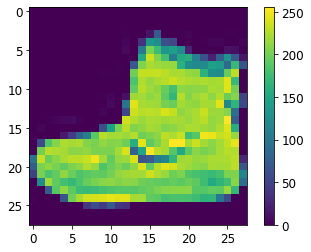

In [27]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Once again, the pixels have values in the range of 0 to 255; let's scale them to the range of [0, 1] as we did before:

In [ ]:
train_images = X_train / 255.0
valid_images = X_valid / 255.0
test_images = X_test / 255.0

Let's see what the first 10 labels are in the training subset:

In [29]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

The class labels are represented numerically, which is what we want for the classifier. However, this makes it harder to interpet the results for us. Class names are not included in the dataset, so let's store them here and see how they correspond to the images:

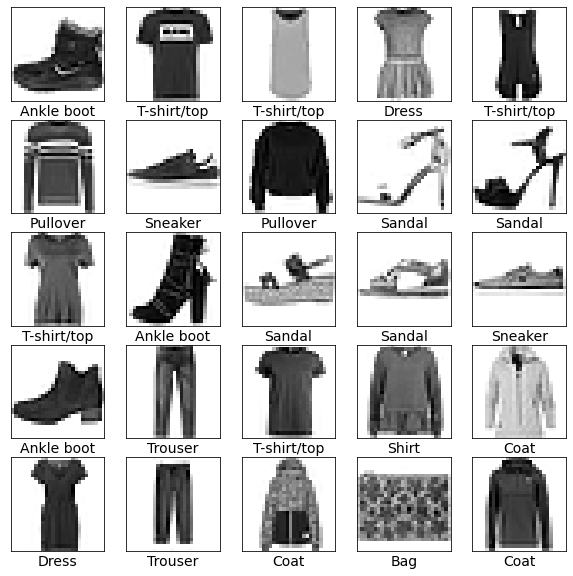

In [30]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

Now, let's apply standadisation to the inputs:

In [31]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Finally, we are ready to run the classification with a CNN. In the following code, we first create a [partial](https://www.learnpython.org/en/Partial_functions) function, which will allow you to change certain parameters in your convolutional layers on the go – for instance, the model below applies a sequence of convolutional layers with varied number of filters (thus making the network deeper using more feature maps), followed by max pooling layers. In the end, it flattens the output, sends it through a couple of regular feedforward neural network layers (`keras.layers.Dense`) using dropout, and applies softmax activation function at the last layer to output prediction across 10 classes.

In [32]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

**Warning**: Convolutional neural networks may be very slow to train. The code below will take quite a long time if you run it on a CPU. You can either simplify the network, or run it for a smaller number of epochs. Alternatively, if you have access to a GPU, it would be preferable to use one, for instance, with [CodaLab](https://colab.research.google.com/notebooks/gpu.ipynb). You will need to select GPU as a hardware accelerator in `Edit` –> `Notebook settings`. The following code allows you use a GPU in CodaLab:

In [33]:
#%tensorflow_version 2.x
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [34]:
#with tf.device('/device:GPU:0'):
#    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#    ...

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 342s 199ms/step - loss: 0.7144 - accuracy: 0.7509 - val_loss: 0.3809 - val_accuracy: 0.8642
Epoch 2/10
1719/1719 [==============================] - 344s 200ms/step - loss: 0.4160 - accuracy: 0.8602 - val_loss: 0.3317 - val_accuracy: 0.8780
Epoch 3/10
1719/1719 [==============================] - 380s 221ms/step - loss: 0.3611 - accuracy: 0.8782 - val_loss: 0.2923 - val_accuracy: 0.8914
Epoch 4/10
1719/1719 [==============================] - 32966s 19s/step - loss: 0.3251 - accuracy: 0.8912 - val_loss: 0.2857 - val_accuracy: 0.8996
Epoch 5/10
1719/1719 [==============================] - 423s 246ms/step - loss: 0.2996 - accuracy: 0.8987 - val_loss: 0.2752 - val_accuracy: 0.9000
Epoch 6/10
1719/1719 [==============================] - 379s 221ms/step - loss: 0.2828 - accuracy: 0.9039 - val_loss: 0.3029 - val_accuracy: 0.8930
Epoch 7/10
1719/1719 [==============================] - 360s 210ms/step - loss: 0.2846 - accuracy: 0.9054 - val_

Now let's look into the output:

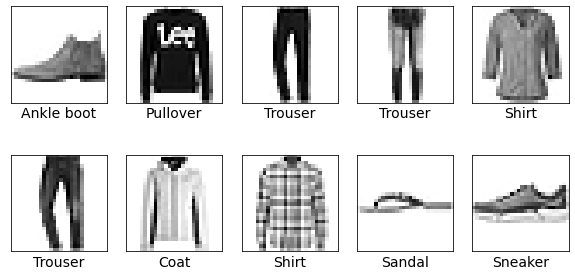

Ankle boot ?= Ankle boot
Pullover ?= Pullover
Trouser ?= Trouser
Trouser ?= Trouser
Shirt ?= Shirt
Trouser ?= Trouser
Coat ?= Coat
Shirt ?= Shirt
Sandal ?= Sandal
Sneaker ?= Sneaker


In [36]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]])
plt.show()

result = tf.argmax(y_pred, axis=1)

for i in range(10):
    print(class_names[result.numpy()[i]], "?=", class_names[y_test[i]])

# Using a Pretrained Model

Finally, you don't have to always build your own model – with a wide availability of powerful CNN models, you can also explore how to apply such pre-trained models to your tasks. For instance, `ResNet50`, a version of the CNN that won the ImageNet challenge in 2015, is just one of the models available via [`Keras`](https://keras.io/api/applications/). You can use it as follows:

In [37]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

The input dimensions for this model have to be [224x224](https://keras.io/api/applications/resnet/#resnet50-function), so you can either resize the image to fit these dimensions:

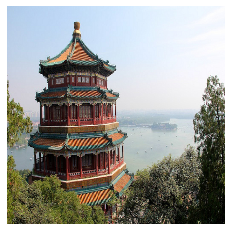

In [38]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Or use one of the following resizing / cropping / padding options – e.g., check [documentation](https://www.tensorflow.org/api_docs/python/tf/image/resize_with_crop_or_pad):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


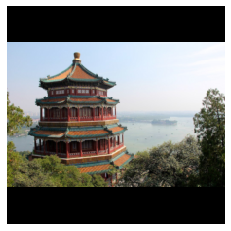

In [39]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

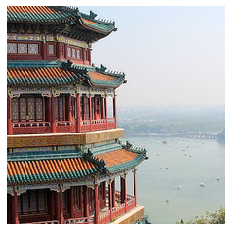

In [40]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

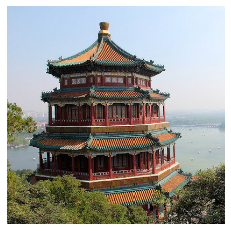

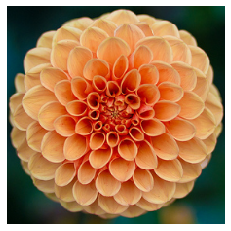

In [41]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

Now let's apply the model to classify the images:

In [42]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

Printing the dimensions for `Y_proba` will tell you that you have an output vector of class probabilities for 2 images across 1000 classes – this is how many classes are contained in the ImageNet dataset that was used to train the model:

In [43]:
Y_proba.shape

(2, 1000)

Of course, these classes won't necessarily coincide with what you have in the images, so let's return the model's top-3 (feel free to change this setting) predictions:

In [44]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



Not bad! The predictions are pretty reasonable, especially for the first image. The second one turns out to be more challenging for the classifier.

# Assignment

Now implement your own CNN model and apply it to the classic [MNIST handwritten digits](https://www.tensorflow.org/datasets/catalog/mnist) database. You have looked into a very similar dataset in the previous practicals. This time:

- Implement the code for a CNN model – the code for the Fashion-MNIST dataset above is a good starting point
- Explore model's decisions and report the results
- Compare the results to those obtained with more "traditional" classifiers, e.g. the ones you built in Practicals 2 and 3. Which types of models perform best?

In [45]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]